In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Adam = optimizers.Adam(lr=0.001)

In [2]:
csv_path_train = 'trainset/J0003_0024_0222_20110307012737_cell_1.csv'
csv_path_test = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
df = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

date_time = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
date_time_test = pd.to_datetime(df_test.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')

In [3]:
df.head()

,CellNo,Resistance,Volt,Temp
0,1,0.259,2.23,-20
1,1,0.260,2.23,-20
2,1,0.259,2.23,-20
3,1,0.259,2.23,-20
4,1,0.259,2.23,-20


In [4]:
df_test.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


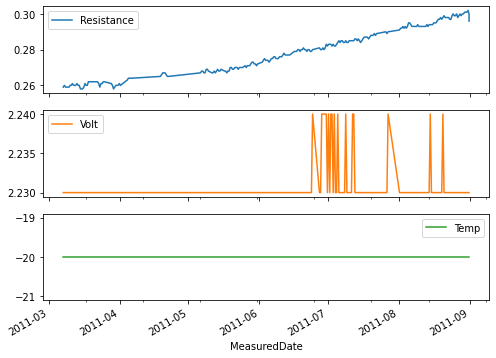

In [5]:
plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


array([<AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>], dtype=object)

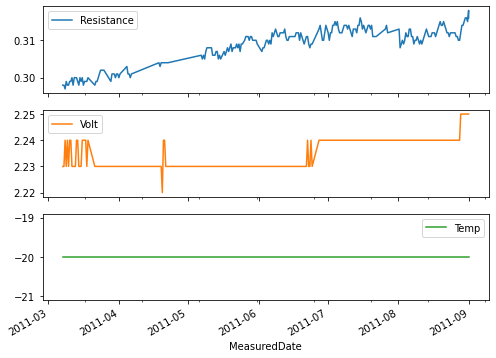

In [6]:
#plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features_test = df_test[plot_cols]
plot_features_test.index = date_time_test
plot_features_test.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CellNo,259.0,1.000000,0.000000,1.000,1.000,1.000,1.0000,1.000
Resistance,259.0,0.278544,0.012893,0.258,0.268,0.279,0.2895,0.302
Volt,259.0,2.230656,0.002481,2.230,2.230,2.230,2.2300,2.240
Temp,259.0,-20.000000,0.000000,-20.000,-20.000,-20.000,-20.0000,-20.000


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices = {name: i for i, name in enumerate(df_test.columns)}

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df[plot_cols])
df_test = scaler.fit_transform(df_test[plot_cols])
df = pd.DataFrame(df)
df_test = pd.DataFrame(df_test)
df.columns = plot_cols
df_test.columns = plot_cols

In [10]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.8)]
test_df = df[int(n*0.8):]
#n_test = len(df_test)
test_df_test = df_test[:int(n*0.7)]
label_df = df_test[int(n*0.7):]

num_features = df.shape[1]
#print(int(n*0.8),int(n*0.2),len(test_df), len(label_df))

In [11]:
df.head()

,Resistance,Volt,Temp
0,0.022727,0.0,0.0
1,0.045455,0.0,0.0
2,0.022727,0.0,0.0
3,0.022727,0.0,0.0
4,0.022727,0.0,0.0


<AxesSubplot:>

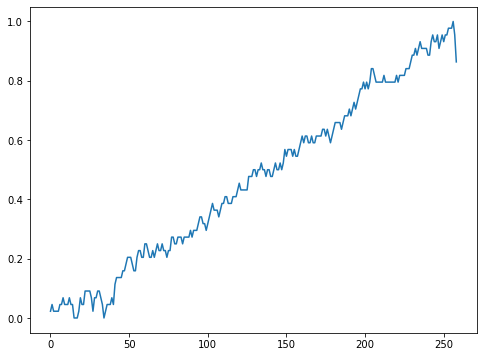

In [12]:
df['Resistance'].plot()

In [13]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [14]:
#w1 = WindowGenerator(input_width = 28, label_width=28, shift=1, label_columns = ['Resistance'])
#w1

In [15]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='Resistance', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    max_n=1
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', c='#2ca02c', zorder=-10)
                #edgecolors='k', c='#2ca02c', s=1)
        if model is not None:
            predictions = model(inputs)
            plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#ff7f0e', zorder=-10)
                   
             #           edgecolors='k', label='Predictions',
              #    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')
    plt.title('01')
    plt.savefig('savefig/each/01.png')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets = None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

def test_test(self):
    return self.make_dataset(self.test_df_test)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.test_test = test_test

Total window size: 174
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
Label indices: [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173]
Label column name(s): None

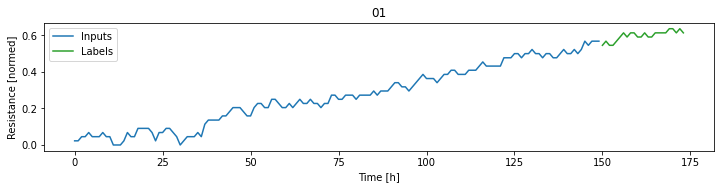

In [19]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=150,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

In [20]:
MAX_EPOCHS = 1500

def compile_and_fit(model, window, patience=500):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    # optimizer=tf.optimizers.Adam(),
                    optimizer=Adam,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [21]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, activation='relu', kernel_initializer='he_normal', dropout=0.1, return_sequences=False),
    # tf.keras.layers.Dropout(rate=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [22]:
history = compile_and_fit(model, multi_window)

Epoch 1/1500
1/1 [==============================] - 4s 4s/step - loss: 0.2059 - mean_absolute_error: 0.2859
Epoch 2/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.2039 - mean_absolute_error: 0.2852
Epoch 3/1500
1/1 [==============================] - 0s 112ms/step - loss: 0.2018 - mean_absolute_error: 0.2845
Epoch 4/1500
1/1 [==============================] - 0s 133ms/step - loss: 0.1996 - mean_absolute_error: 0.2837
Epoch 5/1500
1/1 [==============================] - 0s 109ms/step - loss: 0.1972 - mean_absolute_error: 0.2829
Epoch 6/1500
1/1 [==============================] - 0s 112ms/step - loss: 0.1947 - mean_absolute_error: 0.2821
Epoch 7/1500
1/1 [==============================] - 0s 115ms/step - loss: 0.1920 - mean_absolute_error: 0.2811
Epoch 8/1500
1/1 [==============================] - 0s 115ms/step - loss: 0.1891 - mean_absolute_error: 0.2801
Epoch 9/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.1859 - mean_absolute_error: 0.2789
Epoc

Epoch 34/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0634 - mean_absolute_error: 0.1498
Epoch 35/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0633 - mean_absolute_error: 0.1511
Epoch 36/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.0629 - mean_absolute_error: 0.1507
Epoch 37/1500
1/1 [==============================] - 0s 117ms/step - loss: 0.0625 - mean_absolute_error: 0.1490
Epoch 38/1500
1/1 [==============================] - 0s 114ms/step - loss: 0.0620 - mean_absolute_error: 0.1464
Epoch 39/1500
1/1 [==============================] - 0s 114ms/step - loss: 0.0615 - mean_absolute_error: 0.1430
Epoch 40/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0609 - mean_absolute_error: 0.1391
Epoch 41/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0604 - mean_absolute_error: 0.1349
Epoch 42/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0600 - mean_absolute_error: 

Epoch 67/1500
1/1 [==============================] - 0s 112ms/step - loss: 0.0579 - mean_absolute_error: 0.1227
Epoch 68/1500
1/1 [==============================] - 0s 117ms/step - loss: 0.0579 - mean_absolute_error: 0.1227
Epoch 69/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0579 - mean_absolute_error: 0.1226
Epoch 70/1500
1/1 [==============================] - 0s 159ms/step - loss: 0.0579 - mean_absolute_error: 0.1224
Epoch 71/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0579 - mean_absolute_error: 0.1223
Epoch 72/1500
1/1 [==============================] - 0s 115ms/step - loss: 0.0579 - mean_absolute_error: 0.1220
Epoch 73/1500
1/1 [==============================] - 0s 148ms/step - loss: 0.0579 - mean_absolute_error: 0.1218
Epoch 74/1500
1/1 [==============================] - 0s 151ms/step - loss: 0.0579 - mean_absolute_error: 0.1215
Epoch 75/1500
1/1 [==============================] - 0s 115ms/step - loss: 0.0579 - mean_absolute_error:

Epoch 100/1500
1/1 [==============================] - 0s 125ms/step - loss: 0.0577 - mean_absolute_error: 0.1200
Epoch 101/1500
1/1 [==============================] - 0s 142ms/step - loss: 0.0577 - mean_absolute_error: 0.1200
Epoch 102/1500
1/1 [==============================] - 0s 109ms/step - loss: 0.0577 - mean_absolute_error: 0.1200
Epoch 103/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0577 - mean_absolute_error: 0.1200
Epoch 104/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0576 - mean_absolute_error: 0.1200
Epoch 105/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0576 - mean_absolute_error: 0.1200
Epoch 106/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0576 - mean_absolute_error: 0.1200
Epoch 107/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0576 - mean_absolute_error: 0.1200
Epoch 108/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0576 - mean_absolute_

Epoch 133/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0575 - mean_absolute_error: 0.1196
Epoch 134/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0575 - mean_absolute_error: 0.1196
Epoch 135/1500
1/1 [==============================] - 0s 111ms/step - loss: 0.0575 - mean_absolute_error: 0.1196
Epoch 136/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0575 - mean_absolute_error: 0.1196
Epoch 137/1500
1/1 [==============================] - 0s 120ms/step - loss: 0.0575 - mean_absolute_error: 0.1196
Epoch 138/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0575 - mean_absolute_error: 0.1196
Epoch 139/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0575 - mean_absolute_error: 0.1196
Epoch 140/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0575 - mean_absolute_error: 0.1196
Epoch 141/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0575 - mean_absolute_e

Epoch 166/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0573 - mean_absolute_error: 0.1194
Epoch 167/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.0573 - mean_absolute_error: 0.1194
Epoch 168/1500
1/1 [==============================] - 0s 117ms/step - loss: 0.0573 - mean_absolute_error: 0.1194
Epoch 169/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.0573 - mean_absolute_error: 0.1194
Epoch 170/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0573 - mean_absolute_error: 0.1194
Epoch 171/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.0573 - mean_absolute_error: 0.1193
Epoch 172/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0573 - mean_absolute_error: 0.1193
Epoch 173/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0573 - mean_absolute_error: 0.1193
Epoch 174/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0572 - mean_absolu

Epoch 199/1500
1/1 [==============================] - 0s 109ms/step - loss: 0.0570 - mean_absolute_error: 0.1191
Epoch 200/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0570 - mean_absolute_error: 0.1191
Epoch 201/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.0570 - mean_absolute_error: 0.1190
Epoch 202/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0570 - mean_absolute_error: 0.1190
Epoch 203/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.0570 - mean_absolute_error: 0.1190
Epoch 204/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0570 - mean_absolute_error: 0.1190
Epoch 205/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.0569 - mean_absolute_error: 0.1190
Epoch 206/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0569 - mean_absolute_error: 0.1190
Epoch 207/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0569 - mean_absolute

Epoch 232/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.0566 - mean_absolute_error: 0.1186
Epoch 233/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0565 - mean_absolute_error: 0.1186
Epoch 234/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0565 - mean_absolute_error: 0.1186
Epoch 235/1500
1/1 [==============================] - 0s 111ms/step - loss: 0.0565 - mean_absolute_error: 0.1185
Epoch 236/1500
1/1 [==============================] - 0s 121ms/step - loss: 0.0565 - mean_absolute_error: 0.1185
Epoch 237/1500
1/1 [==============================] - 0s 138ms/step - loss: 0.0565 - mean_absolute_error: 0.1185
Epoch 238/1500
1/1 [==============================] - 0s 118ms/step - loss: 0.0565 - mean_absolute_error: 0.1185
Epoch 239/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0564 - mean_absolute_error: 0.1185
Epoch 240/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0564 - mean_absolu

Epoch 265/1500
1/1 [==============================] - 0s 114ms/step - loss: 0.0559 - mean_absolute_error: 0.1178
Epoch 266/1500
1/1 [==============================] - 0s 142ms/step - loss: 0.0559 - mean_absolute_error: 0.1178
Epoch 267/1500
1/1 [==============================] - 0s 112ms/step - loss: 0.0558 - mean_absolute_error: 0.1178
Epoch 268/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.0558 - mean_absolute_error: 0.1178
Epoch 269/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0558 - mean_absolute_error: 0.1177
Epoch 270/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0558 - mean_absolute_error: 0.1177
Epoch 271/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0557 - mean_absolute_error: 0.1177
Epoch 272/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.0557 - mean_absolute_error: 0.1176
Epoch 273/1500
1/1 [==============================] - 0s 126ms/step - loss: 0.0557 - mean_absolu

Epoch 298/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.0549 - mean_absolute_error: 0.1167
Epoch 299/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.0549 - mean_absolute_error: 0.1167
Epoch 300/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0548 - mean_absolute_error: 0.1166
Epoch 301/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.0548 - mean_absolute_error: 0.1166
Epoch 302/1500
1/1 [==============================] - 0s 132ms/step - loss: 0.0548 - mean_absolute_error: 0.1165
Epoch 303/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.0547 - mean_absolute_error: 0.1165
Epoch 304/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0547 - mean_absolute_error: 0.1165
Epoch 305/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0547 - mean_absolute_error: 0.1164
Epoch 306/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0546 - mean_absolute

Epoch 331/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0536 - mean_absolute_error: 0.1151
Epoch 332/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0536 - mean_absolute_error: 0.1150
Epoch 333/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0535 - mean_absolute_error: 0.1150
Epoch 334/1500
1/1 [==============================] - 0s 94ms/step - loss: 0.0535 - mean_absolute_error: 0.1149
Epoch 335/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0534 - mean_absolute_error: 0.1148
Epoch 336/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0534 - mean_absolute_error: 0.1148
Epoch 337/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0533 - mean_absolute_error: 0.1147
Epoch 338/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0533 - mean_absolute_error: 0.1146
Epoch 339/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.0532 - mean_absolute_e

Epoch 364/1500
1/1 [==============================] - 0s 156ms/step - loss: 0.0521 - mean_absolute_error: 0.1128
Epoch 365/1500
1/1 [==============================] - 0s 126ms/step - loss: 0.0520 - mean_absolute_error: 0.1128
Epoch 366/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0520 - mean_absolute_error: 0.1127
Epoch 367/1500
1/1 [==============================] - 0s 146ms/step - loss: 0.0519 - mean_absolute_error: 0.1126
Epoch 368/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0519 - mean_absolute_error: 0.1125
Epoch 369/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0518 - mean_absolute_error: 0.1124
Epoch 370/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0518 - mean_absolute_error: 0.1124
Epoch 371/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0517 - mean_absolute_error: 0.1123
Epoch 372/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0517 - mean_absolut

Epoch 397/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0505 - mean_absolute_error: 0.1101
Epoch 398/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0504 - mean_absolute_error: 0.1100
Epoch 399/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0504 - mean_absolute_error: 0.1099
Epoch 400/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0503 - mean_absolute_error: 0.1098
Epoch 401/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0503 - mean_absolute_error: 0.1097
Epoch 402/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0503 - mean_absolute_error: 0.1096
Epoch 403/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0502 - mean_absolute_error: 0.1095
Epoch 404/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0502 - mean_absolute_error: 0.1094
Epoch 405/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0501 - mean_absolute_e

Epoch 430/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.0491 - mean_absolute_error: 0.1071
Epoch 431/1500
1/1 [==============================] - 0s 124ms/step - loss: 0.0491 - mean_absolute_error: 0.1070
Epoch 432/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0491 - mean_absolute_error: 0.1070
Epoch 433/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0490 - mean_absolute_error: 0.1069
Epoch 434/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0490 - mean_absolute_error: 0.1068
Epoch 435/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0490 - mean_absolute_error: 0.1068
Epoch 436/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0489 - mean_absolute_error: 0.1067
Epoch 437/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.0489 - mean_absolute_error: 0.1066
Epoch 438/1500
1/1 [==============================] - 0s 118ms/step - loss: 0.0489 - mean_absolu

Epoch 463/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.0481 - mean_absolute_error: 0.1051
Epoch 464/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0481 - mean_absolute_error: 0.1051
Epoch 465/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0480 - mean_absolute_error: 0.1050
Epoch 466/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0480 - mean_absolute_error: 0.1049
Epoch 467/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0480 - mean_absolute_error: 0.1049
Epoch 468/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0479 - mean_absolute_error: 0.1048
Epoch 469/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0479 - mean_absolute_error: 0.1048
Epoch 470/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0479 - mean_absolute_error: 0.1047
Epoch 471/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0479 - mean_absolute_e

Epoch 496/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.0471 - mean_absolute_error: 0.1032
Epoch 497/1500
1/1 [==============================] - 0s 94ms/step - loss: 0.0470 - mean_absolute_error: 0.1031
Epoch 498/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0470 - mean_absolute_error: 0.1031
Epoch 499/1500
1/1 [==============================] - 0s 90ms/step - loss: 0.0470 - mean_absolute_error: 0.1030
Epoch 500/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0469 - mean_absolute_error: 0.1029
Epoch 501/1500
1/1 [==============================] - 0s 114ms/step - loss: 0.0469 - mean_absolute_error: 0.1029
Epoch 502/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.0468 - mean_absolute_error: 0.1028
Epoch 503/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0468 - mean_absolute_error: 0.1028
Epoch 504/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0468 - mean_absolute_err

Epoch 529/1500
1/1 [==============================] - 0s 112ms/step - loss: 0.0457 - mean_absolute_error: 0.1010
Epoch 530/1500
1/1 [==============================] - 0s 113ms/step - loss: 0.0456 - mean_absolute_error: 0.1009
Epoch 531/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0456 - mean_absolute_error: 0.1008
Epoch 532/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0455 - mean_absolute_error: 0.1008
Epoch 533/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0455 - mean_absolute_error: 0.1007
Epoch 534/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0454 - mean_absolute_error: 0.1006
Epoch 535/1500
1/1 [==============================] - 0s 122ms/step - loss: 0.0454 - mean_absolute_error: 0.1005
Epoch 536/1500
1/1 [==============================] - 0s 136ms/step - loss: 0.0453 - mean_absolute_error: 0.1004
Epoch 537/1500
1/1 [==============================] - 0s 111ms/step - loss: 0.0453 - mean_absolute_

Epoch 562/1500
1/1 [==============================] - 0s 115ms/step - loss: 0.0438 - mean_absolute_error: 0.0980
Epoch 563/1500
1/1 [==============================] - 0s 113ms/step - loss: 0.0437 - mean_absolute_error: 0.0979
Epoch 564/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0436 - mean_absolute_error: 0.0978
Epoch 565/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0436 - mean_absolute_error: 0.0977
Epoch 566/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0435 - mean_absolute_error: 0.0976
Epoch 567/1500
1/1 [==============================] - 0s 111ms/step - loss: 0.0434 - mean_absolute_error: 0.0975
Epoch 568/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0433 - mean_absolute_error: 0.0974
Epoch 569/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0433 - mean_absolute_error: 0.0973
Epoch 570/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0432 - mean_absolute

Epoch 595/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0413 - mean_absolute_error: 0.0944
Epoch 596/1500
1/1 [==============================] - 0s 94ms/step - loss: 0.0413 - mean_absolute_error: 0.0943
Epoch 597/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0412 - mean_absolute_error: 0.0942
Epoch 598/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0411 - mean_absolute_error: 0.0941
Epoch 599/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.0410 - mean_absolute_error: 0.0940
Epoch 600/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0410 - mean_absolute_error: 0.0938
Epoch 601/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0409 - mean_absolute_error: 0.0937
Epoch 602/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0408 - mean_absolute_error: 0.0936
Epoch 603/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0407 - mean_absolute_erro

Epoch 628/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0387 - mean_absolute_error: 0.0903
Epoch 629/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0387 - mean_absolute_error: 0.0902
Epoch 630/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0386 - mean_absolute_error: 0.0901
Epoch 631/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0385 - mean_absolute_error: 0.0900
Epoch 632/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0384 - mean_absolute_error: 0.0898
Epoch 633/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.0384 - mean_absolute_error: 0.0897
Epoch 634/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.0383 - mean_absolute_error: 0.0896
Epoch 635/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.0382 - mean_absolute_error: 0.0895
Epoch 636/1500
1/1 [==============================] - 0s 113ms/step - loss: 0.0381 - mean_absolu

Epoch 661/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0361 - mean_absolute_error: 0.0873
Epoch 662/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0360 - mean_absolute_error: 0.0872
Epoch 663/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0359 - mean_absolute_error: 0.0871
Epoch 664/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0358 - mean_absolute_error: 0.0870
Epoch 665/1500
1/1 [==============================] - 0s 112ms/step - loss: 0.0358 - mean_absolute_error: 0.0869
Epoch 666/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0357 - mean_absolute_error: 0.0868
Epoch 667/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0356 - mean_absolute_error: 0.0868
Epoch 668/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0355 - mean_absolute_error: 0.0867
Epoch 669/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0354 - mean_absolu

Epoch 694/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0335 - mean_absolute_error: 0.0852
Epoch 695/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0334 - mean_absolute_error: 0.0851
Epoch 696/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0333 - mean_absolute_error: 0.0850
Epoch 697/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0333 - mean_absolute_error: 0.0849
Epoch 698/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0332 - mean_absolute_error: 0.0849
Epoch 699/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0331 - mean_absolute_error: 0.0848
Epoch 700/1500
1/1 [==============================] - 0s 111ms/step - loss: 0.0331 - mean_absolute_error: 0.0847
Epoch 701/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0330 - mean_absolute_error: 0.0846
Epoch 702/1500
1/1 [==============================] - 0s 116ms/step - loss: 0.0330 - mean_absolute_

Epoch 727/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.0316 - mean_absolute_error: 0.0826
Epoch 728/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0315 - mean_absolute_error: 0.0825
Epoch 729/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0315 - mean_absolute_error: 0.0824
Epoch 730/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0314 - mean_absolute_error: 0.0824
Epoch 731/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0314 - mean_absolute_error: 0.0823
Epoch 732/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0313 - mean_absolute_error: 0.0822
Epoch 733/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0313 - mean_absolute_error: 0.0822
Epoch 734/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.0312 - mean_absolute_error: 0.0821
Epoch 735/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0312 - mean_absolute_e

Epoch 760/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0299 - mean_absolute_error: 0.0803
Epoch 761/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0298 - mean_absolute_error: 0.0802
Epoch 762/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0298 - mean_absolute_error: 0.0801
Epoch 763/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0297 - mean_absolute_error: 0.0801
Epoch 764/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0296 - mean_absolute_error: 0.0800
Epoch 765/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0296 - mean_absolute_error: 0.0799
Epoch 766/1500
1/1 [==============================] - 0s 94ms/step - loss: 0.0295 - mean_absolute_error: 0.0798
Epoch 767/1500
1/1 [==============================] - 0s 94ms/step - loss: 0.0295 - mean_absolute_error: 0.0797
Epoch 768/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0294 - mean_absolute_error

Epoch 793/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0276 - mean_absolute_error: 0.0768
Epoch 794/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0275 - mean_absolute_error: 0.0766
Epoch 795/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0274 - mean_absolute_error: 0.0765
Epoch 796/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0273 - mean_absolute_error: 0.0763
Epoch 797/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0273 - mean_absolute_error: 0.0762
Epoch 798/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0272 - mean_absolute_error: 0.0761
Epoch 799/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0271 - mean_absolute_error: 0.0759
Epoch 800/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0270 - mean_absolute_error: 0.0758
Epoch 801/1500
1/1 [==============================] - 0s 115ms/step - loss: 0.0269 - mean_absolute_

Epoch 826/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0236 - mean_absolute_error: 0.0702
Epoch 827/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0234 - mean_absolute_error: 0.0699
Epoch 828/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0232 - mean_absolute_error: 0.0696
Epoch 829/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0230 - mean_absolute_error: 0.0693
Epoch 830/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0228 - mean_absolute_error: 0.0690
Epoch 831/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0227 - mean_absolute_error: 0.0687
Epoch 832/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0225 - mean_absolute_error: 0.0685
Epoch 833/1500
1/1 [==============================] - 0s 92ms/step - loss: 0.0223 - mean_absolute_error: 0.0682
Epoch 834/1500
1/1 [==============================] - 0s 94ms/step - loss: 0.0220 - mean_absolute_erro

Epoch 859/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0167 - mean_absolute_error: 0.0627
Epoch 860/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0165 - mean_absolute_error: 0.0625
Epoch 861/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0163 - mean_absolute_error: 0.0622
Epoch 862/1500
1/1 [==============================] - 0s 120ms/step - loss: 0.0161 - mean_absolute_error: 0.0620
Epoch 863/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0159 - mean_absolute_error: 0.0617
Epoch 864/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0157 - mean_absolute_error: 0.0614
Epoch 865/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0155 - mean_absolute_error: 0.0612
Epoch 866/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0154 - mean_absolute_error: 0.0609
Epoch 867/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0152 - mean_absolute_err

Epoch 892/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.0113 - mean_absolute_error: 0.0523
Epoch 893/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0112 - mean_absolute_error: 0.0520
Epoch 894/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.0111 - mean_absolute_error: 0.0517
Epoch 895/1500
1/1 [==============================] - 0s 118ms/step - loss: 0.0110 - mean_absolute_error: 0.0514
Epoch 896/1500
1/1 [==============================] - 0s 115ms/step - loss: 0.0108 - mean_absolute_error: 0.0510
Epoch 897/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0107 - mean_absolute_error: 0.0508
Epoch 898/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0106 - mean_absolute_error: 0.0502
Epoch 899/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.0106 - mean_absolute_error: 0.0509
Epoch 900/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0104 - mean_absolu

Epoch 925/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0082 - mean_absolute_error: 0.0436
Epoch 926/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0081 - mean_absolute_error: 0.0435
Epoch 927/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.0081 - mean_absolute_error: 0.0432
Epoch 928/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0080 - mean_absolute_error: 0.0430
Epoch 929/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0079 - mean_absolute_error: 0.0429
Epoch 930/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0079 - mean_absolute_error: 0.0427
Epoch 931/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0078 - mean_absolute_error: 0.0424
Epoch 932/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0077 - mean_absolute_error: 0.0423
Epoch 933/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0077 - mean_absolute_

Epoch 958/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.0064 - mean_absolute_error: 0.0379
Epoch 959/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0064 - mean_absolute_error: 0.0377
Epoch 960/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0063 - mean_absolute_error: 0.0376
Epoch 961/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.0063 - mean_absolute_error: 0.0374
Epoch 962/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0062 - mean_absolute_error: 0.0373
Epoch 963/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.0062 - mean_absolute_error: 0.0371
Epoch 964/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0062 - mean_absolute_error: 0.0370
Epoch 965/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0061 - mean_absolute_error: 0.0368
Epoch 966/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0061 - mean_absolute_e

Epoch 991/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0052 - mean_absolute_error: 0.0331
Epoch 992/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0051 - mean_absolute_error: 0.0330
Epoch 993/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0051 - mean_absolute_error: 0.0329
Epoch 994/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.0051 - mean_absolute_error: 0.0327
Epoch 995/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0051 - mean_absolute_error: 0.0326
Epoch 996/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0050 - mean_absolute_error: 0.0325
Epoch 997/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0050 - mean_absolute_error: 0.0323
Epoch 998/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0050 - mean_absolute_error: 0.0322
Epoch 999/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0049 - mean_absolute_er

Epoch 1024/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0042 - mean_absolute_error: 0.0292
Epoch 1025/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0042 - mean_absolute_error: 0.0291
Epoch 1026/1500
1/1 [==============================] - 0s 111ms/step - loss: 0.0041 - mean_absolute_error: 0.0289
Epoch 1027/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0041 - mean_absolute_error: 0.0288
Epoch 1028/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0041 - mean_absolute_error: 0.0287
Epoch 1029/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0040 - mean_absolute_error: 0.0286
Epoch 1030/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0040 - mean_absolute_error: 0.0285
Epoch 1031/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0040 - mean_absolute_error: 0.0284
Epoch 1032/1500
1/1 [==============================] - 0s 94ms/step - loss: 0.0040 - mean_abso

Epoch 1057/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0034 - mean_absolute_error: 0.0257
Epoch 1058/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0033 - mean_absolute_error: 0.0256
Epoch 1059/1500
1/1 [==============================] - 0s 93ms/step - loss: 0.0033 - mean_absolute_error: 0.0255
Epoch 1060/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0033 - mean_absolute_error: 0.0254
Epoch 1061/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0033 - mean_absolute_error: 0.0253
Epoch 1062/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.0032 - mean_absolute_error: 0.0252
Epoch 1063/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.0032 - mean_absolute_error: 0.0251
Epoch 1064/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0032 - mean_absolute_error: 0.0250
Epoch 1065/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0032 - mean_

Epoch 1090/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0027 - mean_absolute_error: 0.0228
Epoch 1091/1500
1/1 [==============================] - 0s 97ms/step - loss: 0.0027 - mean_absolute_error: 0.0227
Epoch 1092/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0026 - mean_absolute_error: 0.0226
Epoch 1093/1500
1/1 [==============================] - 0s 109ms/step - loss: 0.0026 - mean_absolute_error: 0.0226
Epoch 1094/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0026 - mean_absolute_error: 0.0225
Epoch 1095/1500
1/1 [==============================] - 0s 148ms/step - loss: 0.0026 - mean_absolute_error: 0.0224
Epoch 1096/1500
1/1 [==============================] - 0s 114ms/step - loss: 0.0026 - mean_absolute_error: 0.0223
Epoch 1097/1500
1/1 [==============================] - 0s 121ms/step - loss: 0.0026 - mean_absolute_error: 0.0223
Epoch 1098/1500
1/1 [==============================] - 0s 126ms/step - loss: 0.0025 - mean

Epoch 1122/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.0022 - mean_absolute_error: 0.0204
Epoch 1123/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0022 - mean_absolute_error: 0.0203
Epoch 1124/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0021 - mean_absolute_error: 0.0203
Epoch 1125/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0021 - mean_absolute_error: 0.0202
Epoch 1126/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0021 - mean_absolute_error: 0.0201
Epoch 1127/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0021 - mean_absolute_error: 0.0201
Epoch 1128/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0021 - mean_absolute_error: 0.0200
Epoch 1129/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0021 - mean_absolute_error: 0.0199
Epoch 1130/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0021 - mean_

Epoch 1155/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0017 - mean_absolute_error: 0.0183
Epoch 1156/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0017 - mean_absolute_error: 0.0182
Epoch 1157/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0017 - mean_absolute_error: 0.0182
Epoch 1158/1500
1/1 [==============================] - 0s 109ms/step - loss: 0.0017 - mean_absolute_error: 0.0181
Epoch 1159/1500
1/1 [==============================] - 0s 110ms/step - loss: 0.0017 - mean_absolute_error: 0.0180
Epoch 1160/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.0017 - mean_absolute_error: 0.0180
Epoch 1161/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.0017 - mean_absolute_error: 0.0179
Epoch 1162/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0016 - mean_absolute_error: 0.0179
Epoch 1163/1500
1/1 [==============================] - 0s 124ms/step - loss: 0.0016 - mean_

Epoch 1187/1500
1/1 [==============================] - 0s 132ms/step - loss: 0.0013 - mean_absolute_error: 0.0165
Epoch 1188/1500
1/1 [==============================] - 0s 140ms/step - loss: 0.0013 - mean_absolute_error: 0.0165
Epoch 1189/1500
1/1 [==============================] - 0s 114ms/step - loss: 0.0013 - mean_absolute_error: 0.0164
Epoch 1190/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.0013 - mean_absolute_error: 0.0164
Epoch 1191/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0013 - mean_absolute_error: 0.0163
Epoch 1192/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0013 - mean_absolute_error: 0.0162
Epoch 1193/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0013 - mean_absolute_error: 0.0162
Epoch 1194/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0013 - mean_absolute_error: 0.0161
Epoch 1195/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0013 - mean

1/1 [==============================] - 0s 101ms/step - loss: 9.8631e-04 - mean_absolute_error: 0.0145
Epoch 1220/1500
1/1 [==============================] - 0s 100ms/step - loss: 9.7556e-04 - mean_absolute_error: 0.0144
Epoch 1221/1500
1/1 [==============================] - 0s 98ms/step - loss: 9.6483e-04 - mean_absolute_error: 0.0144
Epoch 1222/1500
1/1 [==============================] - 0s 98ms/step - loss: 9.5414e-04 - mean_absolute_error: 0.0143
Epoch 1223/1500
1/1 [==============================] - 0s 104ms/step - loss: 9.4347e-04 - mean_absolute_error: 0.0142
Epoch 1224/1500
1/1 [==============================] - 0s 103ms/step - loss: 9.3283e-04 - mean_absolute_error: 0.0142
Epoch 1225/1500
1/1 [==============================] - 0s 99ms/step - loss: 9.2223e-04 - mean_absolute_error: 0.0141
Epoch 1226/1500
1/1 [==============================] - 0s 98ms/step - loss: 9.1165e-04 - mean_absolute_error: 0.0140
Epoch 1227/1500
1/1 [==============================] - 0s 98ms/step - loss: 

1/1 [==============================] - 0s 102ms/step - loss: 6.6001e-04 - mean_absolute_error: 0.0122
Epoch 1252/1500
1/1 [==============================] - 0s 98ms/step - loss: 6.5057e-04 - mean_absolute_error: 0.0121
Epoch 1253/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.4118e-04 - mean_absolute_error: 0.0120
Epoch 1254/1500
1/1 [==============================] - 0s 100ms/step - loss: 6.3185e-04 - mean_absolute_error: 0.0119
Epoch 1255/1500
1/1 [==============================] - 0s 102ms/step - loss: 6.2259e-04 - mean_absolute_error: 0.0119
Epoch 1256/1500
1/1 [==============================] - 0s 101ms/step - loss: 6.1338e-04 - mean_absolute_error: 0.0118
Epoch 1257/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.0423e-04 - mean_absolute_error: 0.0117
Epoch 1258/1500
1/1 [==============================] - 0s 143ms/step - loss: 5.9515e-04 - mean_absolute_error: 0.0116
Epoch 1259/1500
1/1 [==============================] - 0s 116ms/step - lo

Epoch 1283/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.9110e-04 - mean_absolute_error: 0.0097
Epoch 1284/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.8395e-04 - mean_absolute_error: 0.0096
Epoch 1285/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.7689e-04 - mean_absolute_error: 0.0095
Epoch 1286/1500
1/1 [==============================] - 0s 102ms/step - loss: 3.6991e-04 - mean_absolute_error: 0.0094
Epoch 1287/1500
1/1 [==============================] - 0s 108ms/step - loss: 3.6302e-04 - mean_absolute_error: 0.0093
Epoch 1288/1500
1/1 [==============================] - 0s 107ms/step - loss: 3.5621e-04 - mean_absolute_error: 0.0093
Epoch 1289/1500
1/1 [==============================] - 0s 111ms/step - loss: 3.4949e-04 - mean_absolute_error: 0.0092
Epoch 1290/1500
1/1 [==============================] - 0s 104ms/step - loss: 3.4285e-04 - mean_absolute_error: 0.0091
Epoch 1291/1500
1/1 [==============================] - 0s

Epoch 1315/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.0457e-04 - mean_absolute_error: 0.0072
Epoch 1316/1500
1/1 [==============================] - 0s 115ms/step - loss: 2.0012e-04 - mean_absolute_error: 0.0071
Epoch 1317/1500
1/1 [==============================] - 0s 117ms/step - loss: 1.9574e-04 - mean_absolute_error: 0.0071
Epoch 1318/1500
1/1 [==============================] - 0s 114ms/step - loss: 1.9145e-04 - mean_absolute_error: 0.0070
Epoch 1319/1500
1/1 [==============================] - 0s 103ms/step - loss: 1.8724e-04 - mean_absolute_error: 0.0069
Epoch 1320/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.8310e-04 - mean_absolute_error: 0.0069
Epoch 1321/1500
1/1 [==============================] - 0s 102ms/step - loss: 1.7904e-04 - mean_absolute_error: 0.0068
Epoch 1322/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.7505e-04 - mean_absolute_error: 0.0067
Epoch 1323/1500
1/1 [==============================] - 0

Epoch 1347/1500
1/1 [==============================] - 0s 100ms/step - loss: 9.7602e-05 - mean_absolute_error: 0.0051
Epoch 1348/1500
1/1 [==============================] - 0s 98ms/step - loss: 9.5289e-05 - mean_absolute_error: 0.0050
Epoch 1349/1500
1/1 [==============================] - 0s 107ms/step - loss: 9.3028e-05 - mean_absolute_error: 0.0050
Epoch 1350/1500
1/1 [==============================] - 0s 103ms/step - loss: 9.0818e-05 - mean_absolute_error: 0.0049
Epoch 1351/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.8660e-05 - mean_absolute_error: 0.0049
Epoch 1352/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.6550e-05 - mean_absolute_error: 0.0048
Epoch 1353/1500
1/1 [==============================] - 0s 110ms/step - loss: 8.4489e-05 - mean_absolute_error: 0.0047
Epoch 1354/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.2475e-05 - mean_absolute_error: 0.0047
Epoch 1355/1500
1/1 [==============================] - 0s

Epoch 1379/1500
1/1 [==============================] - 0s 106ms/step - loss: 4.5150e-05 - mean_absolute_error: 0.0035
Epoch 1380/1500
1/1 [==============================] - 0s 123ms/step - loss: 4.4086e-05 - mean_absolute_error: 0.0034
Epoch 1381/1500
1/1 [==============================] - 0s 113ms/step - loss: 4.3049e-05 - mean_absolute_error: 0.0034
Epoch 1382/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.2038e-05 - mean_absolute_error: 0.0033
Epoch 1383/1500
1/1 [==============================] - 0s 110ms/step - loss: 4.1052e-05 - mean_absolute_error: 0.0033
Epoch 1384/1500
1/1 [==============================] - 0s 131ms/step - loss: 4.0091e-05 - mean_absolute_error: 0.0033
Epoch 1385/1500
1/1 [==============================] - 0s 112ms/step - loss: 3.9154e-05 - mean_absolute_error: 0.0032
Epoch 1386/1500
1/1 [==============================] - 0s 99ms/step - loss: 3.8241e-05 - mean_absolute_error: 0.0032
Epoch 1387/1500
1/1 [==============================] - 0s

Epoch 1411/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.1584e-05 - mean_absolute_error: 0.0023
Epoch 1412/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.1114e-05 - mean_absolute_error: 0.0023
Epoch 1413/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.0655e-05 - mean_absolute_error: 0.0023
Epoch 1414/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.0207e-05 - mean_absolute_error: 0.0022
Epoch 1415/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.9771e-05 - mean_absolute_error: 0.0022
Epoch 1416/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.9345e-05 - mean_absolute_error: 0.0022
Epoch 1417/1500
1/1 [==============================] - 0s 100ms/step - loss: 1.8930e-05 - mean_absolute_error: 0.0022
Epoch 1418/1500
1/1 [==============================] - 0s 97ms/step - loss: 1.8525e-05 - mean_absolute_error: 0.0021
Epoch 1419/1500
1/1 [==============================] - 0s 

Epoch 1443/1500
1/1 [==============================] - 0s 126ms/step - loss: 1.1043e-05 - mean_absolute_error: 0.0016
Epoch 1444/1500
1/1 [==============================] - 0s 142ms/step - loss: 1.0827e-05 - mean_absolute_error: 0.0016
Epoch 1445/1500
1/1 [==============================] - 0s 101ms/step - loss: 1.0615e-05 - mean_absolute_error: 0.0015
Epoch 1446/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.0408e-05 - mean_absolute_error: 0.0015
Epoch 1447/1500
1/1 [==============================] - 0s 106ms/step - loss: 1.0206e-05 - mean_absolute_error: 0.0015
Epoch 1448/1500
1/1 [==============================] - 0s 110ms/step - loss: 1.0008e-05 - mean_absolute_error: 0.0015
Epoch 1449/1500
1/1 [==============================] - 0s 106ms/step - loss: 9.8152e-06 - mean_absolute_error: 0.0015
Epoch 1450/1500
1/1 [==============================] - 0s 122ms/step - loss: 9.6263e-06 - mean_absolute_error: 0.0015
Epoch 1451/1500
1/1 [==============================] - 0

Epoch 1475/1500
1/1 [==============================] - 0s 102ms/step - loss: 6.0280e-06 - mean_absolute_error: 0.0011
Epoch 1476/1500
1/1 [==============================] - 0s 147ms/step - loss: 5.9199e-06 - mean_absolute_error: 0.0011
Epoch 1477/1500
1/1 [==============================] - 0s 112ms/step - loss: 5.8139e-06 - mean_absolute_error: 0.0011
Epoch 1478/1500
1/1 [==============================] - 0s 112ms/step - loss: 5.7100e-06 - mean_absolute_error: 0.0011
Epoch 1479/1500
1/1 [==============================] - 0s 107ms/step - loss: 5.6082e-06 - mean_absolute_error: 0.0011
Epoch 1480/1500
1/1 [==============================] - 0s 124ms/step - loss: 5.5084e-06 - mean_absolute_error: 0.0011
Epoch 1481/1500
1/1 [==============================] - 0s 133ms/step - loss: 5.4106e-06 - mean_absolute_error: 0.0011
Epoch 1482/1500
1/1 [==============================] - 0s 101ms/step - loss: 5.3148e-06 - mean_absolute_error: 0.0011
Epoch 1483/1500
1/1 [==============================] - 0

In [23]:
#pred = model.predict(test_df)

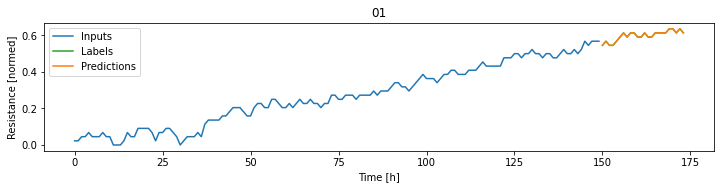

In [24]:
IPython.display.clear_output()

#multi_val_performance = model.evaluate(multi_window.val)
#multi_performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

In [25]:
test_df_test.shape()

TypeError: 'tuple' object is not callable

In [ ]:
pred = model.predict(test_df_test)